In [1]:
!pip install datasets pillow pandas tqdm

In [12]:
## STEP 1: IMPORTS AND CONFIGURATION

import os
import json
from datasets import load_dataset
from PIL import Image
from collections import defaultdict
from tqdm import tqdm
import random

c:\Projects\Smart_Vision\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 25 Selected Classes with COCO Category IDs

**Vehicles:** car(3), truck(8), bus(6), motorcycle(4), bicycle(2), airplane(5)  
**Person:** person(1)  
**Outdoor:** traffic light(10), stop sign(13), bench(15)  
**Animals:** dog(18), cat(17), horse(19), bird(16), cow(21), elephant(22)  
**Kitchen & Food:** bottle(44), cup(47), bowl(51), pizza(59), cake(61)  
**Furniture:** chair(62), couch(63), bed(65), potted plant(64)

In [13]:
# =========================================================
# STREAMING-ONLY COCO CLASS MAPPING (NO DATA DOWNLOAD)
# =========================================================

from datasets import load_dataset, load_dataset_builder

# ---------------------------------------------------------
# 1️⃣ Load ONLY dataset metadata (no images, no data files)
# ---------------------------------------------------------
builder = load_dataset_builder("detection-datasets/coco")

HF_COCO_CLASS_NAMES = (
    builder.info.features["objects"]["category"].feature.names
)

print("✅ COCO class names loaded from Hugging Face metadata")
print(f"Total COCO classes: {len(HF_COCO_CLASS_NAMES)}")

# ---------------------------------------------------------
# 2️⃣ Define your 25 selected classes (NAMES ONLY)
# ---------------------------------------------------------
SELECTED_CLASS_NAMES = [
    'person','bicycle','car','motorcycle','airplane','bus','truck',
    'traffic light','stop sign','bench','bird','cat','dog','horse',
    'cow','elephant','bottle','cup','bowl','pizza','cake',
    'chair','couch','bed','potted plant'
]

# ---------------------------------------------------------
# 3️⃣ Build class-name → ID mapping DYNAMICALLY
# ---------------------------------------------------------
SELECTED_CLASSES = {
    name: HF_COCO_CLASS_NAMES.index(name)
    for name in SELECTED_CLASS_NAMES
}

print("\n✅ Selected class mapping (Hugging Face COCO indices):")
for k, v in SELECTED_CLASSES.items():
    print(f"{k:15s} → {v}")

# ---------------------------------------------------------
# 4️⃣ Load COCO dataset in STREAMING mode (images only)
# ---------------------------------------------------------
dataset = load_dataset(
    "detection-datasets/coco",
    split="train",
    streaming=True
)

print("\n📥 COCO dataset loaded in STREAMING mode (no download)")
IMAGES_PER_CLASS = 100
BASE_DIR = "smartvision_dataset"


✅ COCO class names loaded from Hugging Face metadata
Total COCO classes: 80

✅ Selected class mapping (Hugging Face COCO indices):
person          → 0
bicycle         → 1
car             → 2
motorcycle      → 3
airplane        → 4
bus             → 5
truck           → 7
traffic light   → 9
stop sign       → 11
bench           → 13
bird            → 14
cat             → 15
dog             → 16
horse           → 17
cow             → 19
elephant        → 20
bottle          → 39
cup             → 41
bowl            → 45
pizza           → 53
cake            → 55
chair           → 56
couch           → 57
bed             → 59
potted plant    → 58

📥 COCO dataset loaded in STREAMING mode (no download)


In [4]:
## STEP 3: COLLECT IMAGES FROM STREAM

print("\n🔍 Starting image collection from COCO dataset stream...")
print(f"🎯 Target: {IMAGES_PER_CLASS} images per class")
print()

# Initialize storage for collected images
class_images = {class_name: [] for class_name in SELECTED_CLASSES.keys()}
class_counts = {class_name: 0 for class_name in SELECTED_CLASSES.keys()}

# Progress tracking
total_collected = 0
images_processed = 0
max_iterations = 50000  # Safety limit

print("⏳ Processing images from stream...")
print("💡 Progress updates every 100 images collected")
print()

# Iterate through streaming dataset
for idx, item in enumerate(dataset):

    images_processed += 1

    # Progress update every 1000 images processed
    if images_processed % 1000 == 0:
        print(f"📊 Processed {images_processed} images | Collected {total_collected}/{len(SELECTED_CLASSES) * IMAGES_PER_CLASS}")

    # Safety check
    if images_processed >= max_iterations:
        print(f"⚠️ Reached safety limit of {max_iterations} iterations")
        break

    # Check if we have enough images for ALL classes
    if all(count >= IMAGES_PER_CLASS for count in class_counts.values()):
        print("🎉 Successfully collected 100 images for ALL classes!")
        break

    # Get annotations from current image
    annotations = item['objects']
    categories = annotations['category']

    # Check if any of our target classes are in this image
    for cat_id in categories:
        for class_name, class_id in SELECTED_CLASSES.items():
            if cat_id == class_id and class_counts[class_name] < IMAGES_PER_CLASS:

                # Store the ACTUAL image data (not just index!)
                class_images[class_name].append({
                    'image': item['image'],           # PIL Image object
                    'annotations': item['objects'],   # Annotations
                    'idx': images_processed           # For naming
                })

                class_counts[class_name] += 1
                total_collected += 1

                # Progress update every 100 collected
                if total_collected % 100 == 0:
                    print(f"✓ Collected {total_collected}/{len(SELECTED_CLASSES) * IMAGES_PER_CLASS} images")

                break  # Only count once per class

print()
print("="*60)
print("📊 COLLECTION COMPLETE:")
print("="*60)
print(f"Images Processed: {images_processed}")
print(f"Images Collected: {total_collected}")
print()
for class_name, count in sorted(class_counts.items()):
    status = "✅" if count >= IMAGES_PER_CLASS else "⚠️"
    print(f"{status} {class_name:20s}: {count:3d} images")
print("="*60)


🔍 Starting image collection from COCO dataset stream...
🎯 Target: 100 images per class

⏳ Processing images from stream...
💡 Progress updates every 100 images collected

✓ Collected 100/2500 images
✓ Collected 200/2500 images
✓ Collected 300/2500 images
✓ Collected 400/2500 images
✓ Collected 500/2500 images
✓ Collected 600/2500 images
✓ Collected 700/2500 images
✓ Collected 800/2500 images
✓ Collected 900/2500 images
✓ Collected 1000/2500 images
✓ Collected 1100/2500 images
✓ Collected 1200/2500 images
✓ Collected 1300/2500 images
✓ Collected 1400/2500 images
✓ Collected 1500/2500 images
✓ Collected 1600/2500 images
📊 Processed 1000 images | Collected 1642/2500
✓ Collected 1700/2500 images
✓ Collected 1800/2500 images
✓ Collected 1900/2500 images
✓ Collected 2000/2500 images
✓ Collected 2100/2500 images
✓ Collected 2200/2500 images
📊 Processed 2000 images | Collected 2273/2500
✓ Collected 2300/2500 images
✓ Collected 2400/2500 images
📊 Processed 3000 images | Collected 2443/2500
📊 Pr

In [5]:
## STEP 4: CREATE FOLDER STRUCTURE

print("\n📁 Creating project folder structure...")
print()

# Create main directory
os.makedirs(BASE_DIR, exist_ok=True)

# Create subdirectories for Classification task
os.makedirs(f"{BASE_DIR}/classification/train", exist_ok=True)
os.makedirs(f"{BASE_DIR}/classification/val", exist_ok=True)
os.makedirs(f"{BASE_DIR}/classification/test", exist_ok=True)

# Create subdirectories for Detection task
os.makedirs(f"{BASE_DIR}/detection/images", exist_ok=True)
os.makedirs(f"{BASE_DIR}/detection/labels", exist_ok=True)

# Create class folders inside train/val/test
for class_name in SELECTED_CLASSES.keys():
    os.makedirs(f"{BASE_DIR}/classification/train/{class_name}", exist_ok=True)
    os.makedirs(f"{BASE_DIR}/classification/val/{class_name}", exist_ok=True)
    os.makedirs(f"{BASE_DIR}/classification/test/{class_name}", exist_ok=True)

print("✅ Folder structure created successfully!")
print()
print("📂 Structure:")
print(f"""
{BASE_DIR}/
├── classification/
│   ├── train/
│   │   ├── person/
│   │   ├── car/
│   │   └── ... (25 class folders)
│   ├── val/
│   │   └── ... (25 class folders)
│   └── test/
│       └── ... (25 class folders)
│
└── detection/
    ├── images/
    └── labels/
""")


📁 Creating project folder structure...

✅ Folder structure created successfully!

📂 Structure:

smartvision_dataset/
├── classification/
│   ├── train/
│   │   ├── person/
│   │   ├── car/
│   │   └── ... (25 class folders)
│   ├── val/
│   │   └── ... (25 class folders)
│   └── test/
│       └── ... (25 class folders)
│
└── detection/
    ├── images/
    └── labels/



In [6]:
print("="*70)
print("🔀 Preparing Train / Val / Test splits (FIXED)")
print("📊 Split Ratio: 70% Train | 15% Val | 15% Test")
print("="*70)

import random

# Storage
train_data = {}
val_data = {}
test_data = {}

metadata = {
    "total_images": 0,
    "classes": {},
    "splits": {"train": 0, "val": 0, "test": 0}
}

# Iterate class-wise
for class_name, items in class_images.items():

    if len(items) == 0:
        print(f"⚠️ No images for class: {class_name}")
        continue

    # 🔥 SHUFFLE ONCE (important)
    random.shuffle(items)

    total = len(items)
    train_end = int(0.7 * total)
    val_end = int(0.85 * total)

    train_items = items[:train_end]
    val_items = items[train_end:val_end]
    test_items = items[val_end:]

    train_data[class_name] = train_items
    val_data[class_name] = val_items
    test_data[class_name] = test_items

    metadata["classes"][class_name] = {
        "train": len(train_items),
        "val": len(val_items),
        "test": len(test_items),
        "total": total
    }

    metadata["splits"]["train"] += len(train_items)
    metadata["splits"]["val"] += len(val_items)
    metadata["splits"]["test"] += len(test_items)
    metadata["total_images"] += total

    print(f"{class_name:20s} → "
          f"Train: {len(train_items)} | "
          f"Val: {len(val_items)} | "
          f"Test: {len(test_items)}")

print("\n✅ Dataset split completed successfully!")


🔀 Preparing Train / Val / Test splits (FIXED)
📊 Split Ratio: 70% Train | 15% Val | 15% Test
person               → Train: 70 | Val: 15 | Test: 15
bicycle              → Train: 70 | Val: 15 | Test: 15
car                  → Train: 70 | Val: 15 | Test: 15
motorcycle           → Train: 70 | Val: 15 | Test: 15
airplane             → Train: 70 | Val: 15 | Test: 15
bus                  → Train: 70 | Val: 15 | Test: 15
truck                → Train: 70 | Val: 15 | Test: 15
traffic light        → Train: 70 | Val: 15 | Test: 15
stop sign            → Train: 70 | Val: 15 | Test: 15
bench                → Train: 70 | Val: 15 | Test: 15
bird                 → Train: 70 | Val: 15 | Test: 15
cat                  → Train: 70 | Val: 15 | Test: 15
dog                  → Train: 70 | Val: 15 | Test: 15
horse                → Train: 70 | Val: 15 | Test: 15
cow                  → Train: 70 | Val: 15 | Test: 15
elephant             → Train: 70 | Val: 15 | Test: 15
bottle               → Train: 70 | Val: 15 |

In [7]:
import os
from PIL import Image
from tqdm import tqdm
import json

print("="*70)
print("💾 STEP 6: SAVING IMAGES TO DISK")
print("="*70)
print()

# PART A: SAVE CLASSIFICATION IMAGES


print("📁 PART A: Saving Classification Images...")
print("   Format: Cropped objects, 224x224 pixels\n")

classification_stats = {'train': 0, 'val': 0, 'test': 0}

# Process each split
for split_name, split_data in [('train', train_data), ('val', val_data), ('test', test_data)]:

    print(f"📂 Processing {split_name.upper()} split...")

    # Process each class
    for class_name, items in tqdm(split_data.items(), desc=f"  {split_name}"):

        class_folder = f"{BASE_DIR}/classification/{split_name}/{class_name}"

        # Save each image
        for img_idx, item in enumerate(items):

            img = item['image']
            annotations = item['annotations']
            bboxes = annotations['bbox']
            categories = annotations['category']

            class_id = SELECTED_CLASSES[class_name]

            # Find bbox for this class
            for bbox, cat_id in zip(bboxes, categories):
                if cat_id == class_id:
                    x, y, w, h = bbox

                    try:
                        # Crop and resize
                        cropped_img = img.crop((x, y, x + w, y + h))
                        cropped_img = cropped_img.resize((224, 224), Image.LANCZOS)

                        # Save
                        img_filename = f"{class_name}_{split_name}_{img_idx:04d}.jpg"
                        img_path = os.path.join(class_folder, img_filename)
                        cropped_img.save(img_path, quality=95)

                        classification_stats[split_name] += 1

                    except Exception as e:
                        print(f"⚠️ Error: {class_name} image {img_idx}: {e}")

                    break

print()
print("="*70)
print("✅ CLASSIFICATION IMAGES SAVED!")
print("="*70)
print(f"📊 Train: {classification_stats['train']} images")
print(f"📊 Val:   {classification_stats['val']} images")
print(f"📊 Test:  {classification_stats['test']} images")
print(f"📊 Total: {sum(classification_stats.values())} images")
print()

💾 STEP 6: SAVING IMAGES TO DISK

📁 PART A: Saving Classification Images...
   Format: Cropped objects, 224x224 pixels

📂 Processing TRAIN split...


  train: 100%|██████████| 25/25 [00:04<00:00,  5.70it/s]


📂 Processing VAL split...


  val: 100%|██████████| 25/25 [00:00<00:00, 25.26it/s]


📂 Processing TEST split...


  test: 100%|██████████| 25/25 [00:01<00:00, 16.85it/s]


✅ CLASSIFICATION IMAGES SAVED!
📊 Train: 1750 images
📊 Val:   375 images
📊 Test:  375 images
📊 Total: 2500 images



In [34]:
bad = False
for f in os.listdir(LABEL_DIR):
    with open(os.path.join(LABEL_DIR, f)) as file:
        for line in file:
            cls = int(line.split()[0])
            if cls < 0 or cls >= len(SELECTED_CLASS_NAMES):
                print("❌ Invalid class id:", cls, "in", f)
                bad = True

if not bad:
    print("✅ All labels are within valid YOLO range")


✅ All labels are within valid YOLO range


📁 PART B: Saving Detection Images & Annotations...
   Format: Full images with YOLO .txt labels

📊 Total detection images: 2125



Saving detection data: 100%|██████████| 2125/2125 [00:05<00:00, 356.51it/s]



✅ DETECTION DATASET CREATED!
📊 Images:     2125
📊 Labels:     2125
📊 Objects:    21543
📊 Avg/image:  10.14

📝 Creating YOLO configuration file...

📊 Saving metadata...

✅ Saved: smartvision_dataset/dataset_metadata.json

🎉 DATASET SETUP COMPLETE!

📁 Location: c:\Projects\Smart_Vision\smartvision_dataset

📂 Classification Dataset:
   ├─ Train:  1750 images (70%)
   ├─ Val:    375 images (15%)
   ├─ Test:   375 images (15%)
   └─ Total:  2500 cropped images (224x224)

📂 Detection Dataset:
   ├─ Images: 2125 full images
   ├─ Labels: 2125 YOLO .txt files
   └─ Objects: 21543 annotated objects

✅ LEARNERS CAN NOW START:
Step 7:  Exploratory Data Analysis (EDA)
Step 8:  Train Classification Models
Step 9:  Train YOLO Detection Model
Step 10: Build Streamlit Application
Step 11: Deploy to Hugging Face Spaces


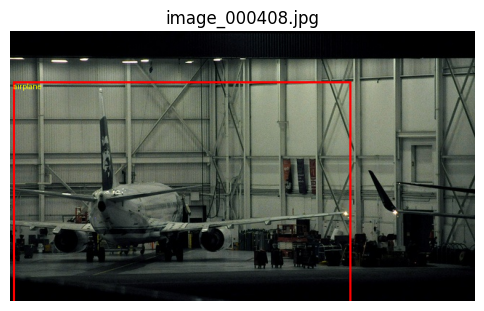

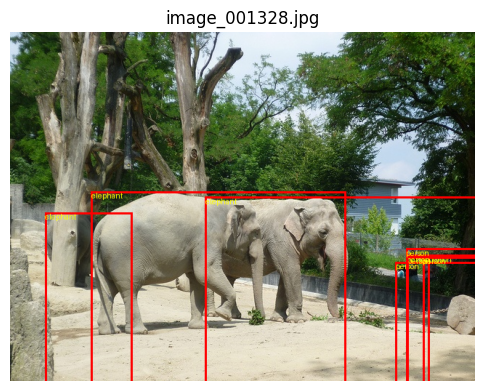

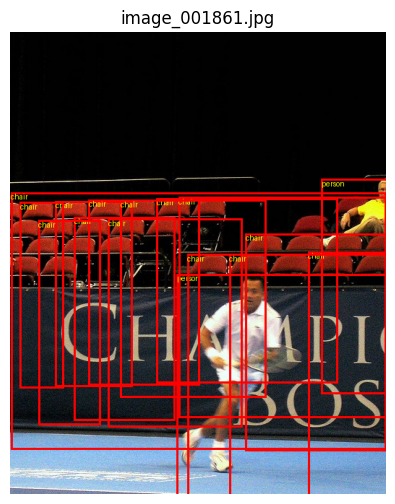

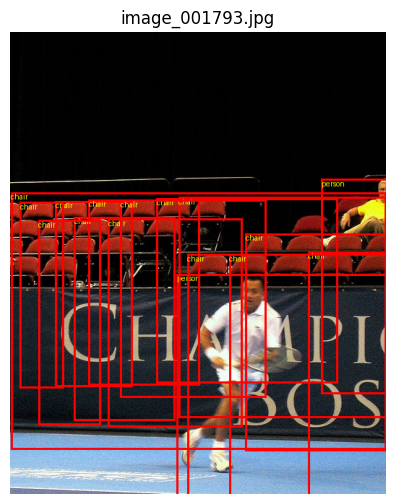

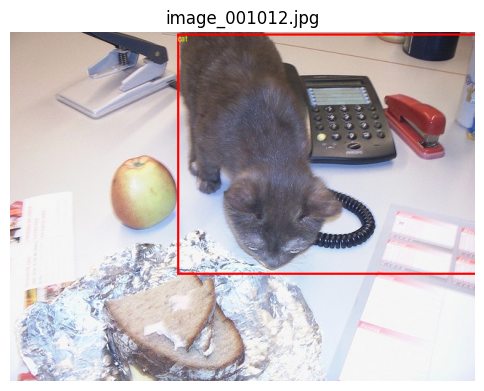

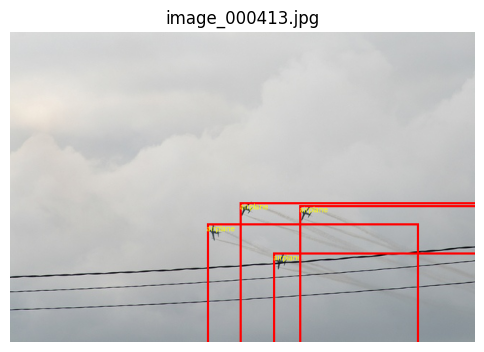

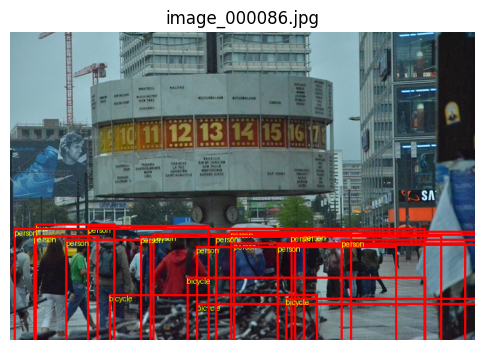

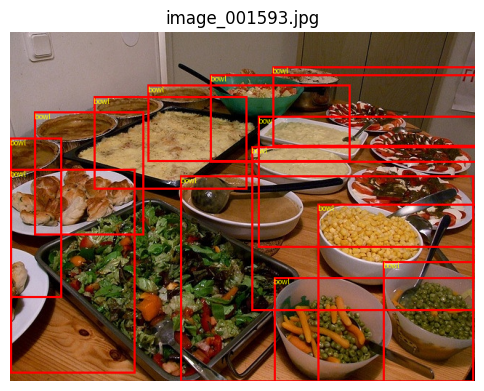

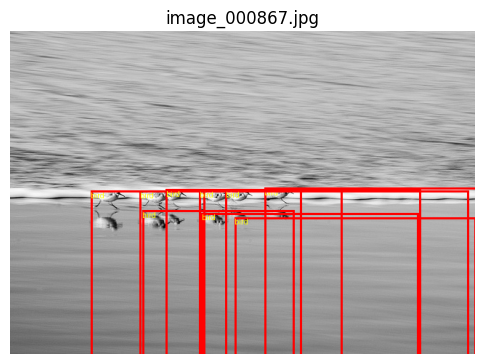

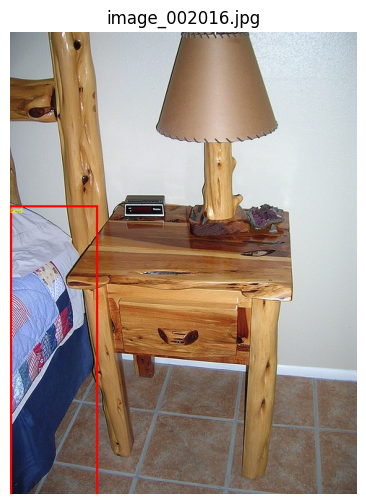

In [33]:
# PART B: SAVE DETECTION IMAGES (YOLO FORMAT)

print("="*70)
print("📁 PART B: Saving Detection Images & Annotations...")
print("   Format: Full images with YOLO .txt labels\n")

detection_stats = {'images': 0, 'annotations': 0, 'objects': 0}

# ✅ CORRECT COCO → YOLO MAPPING (DO NOT CHANGE VARIABLE NAME)
coco_to_yolo = {
    HF_COCO_CLASS_NAMES.index(name): idx
    for idx, name in enumerate(SELECTED_CLASS_NAMES)
}

# Combine train + val for detection
all_detection_data = []
for class_name in SELECTED_CLASSES.keys():
    all_detection_data.extend(train_data.get(class_name, []))
    all_detection_data.extend(val_data.get(class_name, []))

print(f"📊 Total detection images: {len(all_detection_data)}\n")

# Save images and create YOLO labels
for img_idx, item in enumerate(tqdm(all_detection_data, desc="Saving detection data")):

    img = item['image']
    img_width, img_height = img.size

    # Save full image
    img_filename = f"image_{img_idx:06d}.jpg"
    img_path = os.path.join(f"{BASE_DIR}/detection/images", img_filename)
    img.save(img_path, quality=95)
    detection_stats['images'] += 1

    # Get annotations
    annotations = item['annotations']
    bboxes = annotations['bbox']
    categories = annotations['category']

    # Create YOLO annotation
    label_filename = f"image_{img_idx:06d}.txt"
    label_path = os.path.join(f"{BASE_DIR}/detection/labels", label_filename)

    yolo_annotations = []
    objects_count = 0

    for bbox, cat_id in zip(bboxes, categories):

        if cat_id not in coco_to_yolo:
            continue

        x, y, w, h = bbox
        if w <= 1 or h <= 1:
            continue

        # Convert to YOLO format (normalized)
        x_center = (x + w / 2) / img_width
        y_center = (y + h / 2) / img_height
        w_norm = w / img_width
        h_norm = h / img_height

        yolo_class_id = coco_to_yolo[cat_id]
        yolo_line = f"{yolo_class_id} {x_center:.6f} {y_center:.6f} {w_norm:.6f} {h_norm:.6f}"
        yolo_annotations.append(yolo_line)
        objects_count += 1

    # Save label file
    if yolo_annotations:
        with open(label_path, 'w') as f:
            f.write('\n'.join(yolo_annotations))
        detection_stats['annotations'] += 1
        detection_stats['objects'] += objects_count

print()
print("="*70)
print("✅ DETECTION DATASET CREATED!")
print("="*70)
print(f"📊 Images:     {detection_stats['images']}")
print(f"📊 Labels:     {detection_stats['annotations']}")
print(f"📊 Objects:    {detection_stats['objects']}")
print(f"📊 Avg/image:  {detection_stats['objects']/detection_stats['images']:.2f}")
print()


# PART C: CREATE YOLO CONFIG FILE

print("📝 Creating YOLO configuration file...\n")

with open(f"{BASE_DIR}/detection/data.yaml", "w") as f:
    f.write(f"path: {os.path.abspath(BASE_DIR)}/detection\n")
    f.write("train: images\nval: images\n\nnames:\n")
    for i, name in enumerate(SELECTED_CLASS_NAMES):
        f.write(f"  {i}: {name}\n")
    f.write(f"\nnc: {len(SELECTED_CLASS_NAMES)}\n")

# PART D: SAVE METADATA

print("📊 Saving metadata...\n")

metadata['classification'] = classification_stats
metadata['detection'] = detection_stats
metadata['dataset_path'] = os.path.abspath(BASE_DIR)

metadata_path = f"{BASE_DIR}/dataset_metadata.json"
with open(metadata_path, 'w') as f:
    json.dump(metadata, indent=2, fp=f)

print(f"✅ Saved: {metadata_path}\n")

print("="*70)
print("🎉 DATASET SETUP COMPLETE!")
print("="*70)
print()
print(f"📁 Location: {os.path.abspath(BASE_DIR)}")
print()
print("📂 Classification Dataset:")
print(f"   ├─ Train:  {classification_stats['train']} images (70%)")
print(f"   ├─ Val:    {classification_stats['val']} images (15%)")
print(f"   ├─ Test:   {classification_stats['test']} images (15%)")
print(f"   └─ Total:  {sum(classification_stats.values())} cropped images (224x224)")
print()
print("📂 Detection Dataset:")
print(f"   ├─ Images: {detection_stats['images']} full images")
print(f"   ├─ Labels: {detection_stats['annotations']} YOLO .txt files")
print(f"   └─ Objects: {detection_stats['objects']} annotated objects")
print()
print("="*70)
print("✅ LEARNERS CAN NOW START:")
print("="*70)
print("Step 7:  Exploratory Data Analysis (EDA)")
print("Step 8:  Train Classification Models")
print("Step 9:  Train YOLO Detection Model")
print("Step 10: Build Streamlit Application")
print("Step 11: Deploy to Hugging Face Spaces")
print("="*70)

import os
import random
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

IMAGE_DIR = f"{BASE_DIR}/detection/images"
LABEL_DIR = f"{BASE_DIR}/detection/labels"

def show_yolo_sample(n=5):
    images = random.sample(os.listdir(IMAGE_DIR), n)

    for img_name in images:
        img_path = os.path.join(IMAGE_DIR, img_name)
        label_path = os.path.join(LABEL_DIR, img_name.replace(".jpg", ".txt"))

        img = Image.open(img_path).convert("RGB")
        draw = ImageDraw.Draw(img)

        w, h = img.size

        if os.path.exists(label_path):
            with open(label_path) as f:
                for line in f:
                    cls, xc, yc, bw, bh = map(float, line.split())
                    cls = int(cls)

                    # Convert YOLO → pixel
                    x1 = (xc - bw/2) * w
                    y1 = (yc - bh/2) * h
                    x2 = (xc + bw/2) * w
                    y2 = (yc + bh/2) * h

                    label = SELECTED_CLASS_NAMES[cls]

                    draw.rectangle([x1, y1, x2, y2], outline="red", width=3)
                    draw.text((x1, y1), label, fill="yellow")

        plt.figure(figsize=(6,6))
        plt.imshow(img)
        plt.title(img_name)
        plt.axis("off")
        plt.show()

# Run this
show_yolo_sample(10)


In [ ]:
import shutil

shutil.make_archive("smartvision_dataset", "zip", "smartvision_dataset")


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import os
import json
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from collections import Counter
import numpy as np


In [ ]:
BASE_DIR = "smartvision_dataset"

with open(os.path.join(BASE_DIR, "dataset_metadata.json"), "r") as f:
    metadata = json.load(f)

print("Total images:", metadata["total_images"])
print("Class distribution:")
metadata["classes"]


In [ ]:
class_names = list(metadata["classes"].keys())
class_counts = [v["total"] for v in metadata["classes"].values()]

plt.figure(figsize=(12,6))
sns.barplot(x=class_names, y=class_counts)
plt.xticks(rotation=90)
plt.title("Class Distribution (25 Classes)")
plt.ylabel("Number of Images")
plt.xlabel("Class Name")
plt.tight_layout()
plt.show()


In [ ]:
splits = ["train", "val", "test"]
split_counts = [
    metadata["splits"]["train"],
    metadata["splits"]["val"],
    metadata["splits"]["test"]
]

plt.figure(figsize=(6,5))
plt.pie(split_counts, labels=splits, autopct='%1.1f%%', startangle=90)
plt.title("Train / Validation / Test Split")
plt.show()


In [ ]:
import random

sample_class = random.choice(os.listdir(f"{BASE_DIR}/classification/train"))
sample_path = os.path.join(BASE_DIR, "classification", "train", sample_class)

sample_images = os.listdir(sample_path)[:6]

plt.figure(figsize=(10,6))
for i, img_name in enumerate(sample_images):
    img = Image.open(os.path.join(sample_path, img_name))
    plt.subplot(2, 3, i+1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(sample_class)

plt.suptitle("Sample Images from Dataset")
plt.tight_layout()
plt.show()


In [ ]:
widths, heights = [], []

for cls in os.listdir(f"{BASE_DIR}/classification/train"):
    cls_path = os.path.join(BASE_DIR, "classification", "train", cls)
    for img_name in os.listdir(cls_path)[:20]:
        img = Image.open(os.path.join(cls_path, img_name))
        w, h = img.size
        widths.append(w)
        heights.append(h)

plt.figure(figsize=(6,4))
plt.scatter(widths, heights, alpha=0.5)
plt.xlabel("Width")
plt.ylabel("Height")
plt.title("Image Resolution Distribution")
plt.show()


Data Augmentation


In [61]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


In [62]:
import tensorflow as tf
from tensorflow.keras import layers

# ===============================
# Load dataset
# ===============================
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "smartvision_dataset/classification/train",
    image_size=(224, 224),
    batch_size=32,
    label_mode="categorical",
    shuffle=True
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "smartvision_dataset/classification/val",
    image_size=(224, 224),
    batch_size=32,
    label_mode="categorical",
    shuffle=False
)

class_names = train_ds.class_names
NUM_CLASSES = len(class_names)

print("Classes:", class_names)
print("Total classes:", NUM_CLASSES)

# ===============================
# Data Augmentation
# ===============================
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.15),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.2),
])
normalization = tf.keras.layers.Rescaling(1./255)

# Normalize pixel values

# Apply preprocessing
train_ds = train_ds.map(
    lambda x, y: (normalization(x), y),
    num_parallel_calls=tf.data.AUTOTUNE
)

train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y),
    num_parallel_calls=tf.data.AUTOTUNE
)

val_ds = val_ds.map(
    lambda x, y: (normalization(x), y),
    num_parallel_calls=tf.data.AUTOTUNE
)

# Improve performance
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)


Found 1750 files belonging to 25 classes.
Found 375 files belonging to 25 classes.
Classes: ['airplane', 'bed', 'bench', 'bicycle', 'bird', 'bottle', 'bowl', 'bus', 'cake', 'car', 'cat', 'chair', 'couch', 'cow', 'cup', 'dog', 'elephant', 'horse', 'motorcycle', 'person', 'pizza', 'potted plant', 'stop sign', 'traffic light', 'truck']
Total classes: 25


Model Training


vgg16

In [ ]:

# =========================
# STEP 3: Build Model
# =========================
base_model = VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3)
)
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.5)(x)
outputs = Dense(NUM_CLASSES, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=outputs)

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

In [ ]:

# =========================
# STEP 4: Train Model
# =========================
checkpoint = ModelCheckpoint(
    "vgg16_best_model.h5",
    monitor="val_accuracy",
    save_best_only=True,
    verbose=1
)

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[checkpoint, early_stop]
)


ResNet50

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Load ResNet50 base
base_model = ResNet50(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3)
)

# Fine-tune last layers
for layer in base_model.layers[:-20]:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.5)(x)
outputs = Dense(NUM_CLASSES, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=outputs)

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

checkpoint = ModelCheckpoint(
    "resnet50_best_model.h5",
    monitor="val_accuracy",
    save_best_only=True,
    verbose=1
)

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[checkpoint, early_stop]
)

mobilenet v2


In [ ]:
from tensorflow.keras.applications import MobileNetV2

base_model = MobileNetV2(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3)
)

base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.4)(x)
outputs = Dense(NUM_CLASSES, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=outputs)

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

checkpoint = ModelCheckpoint(
    "mobilenetv2_best_model.h5",
    monitor="val_accuracy",
    save_best_only=True,
    verbose=1
)

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[checkpoint, early_stop]
)


efficientnetB0

In [ ]:
from tensorflow.keras.applications import EfficientNetB0

base_model = EfficientNetB0(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3)
)

base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.5)(x)
outputs = Dense(NUM_CLASSES, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=outputs)

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

checkpoint = ModelCheckpoint(
    "efficientnetb0_best_model.h5",
    monitor="val_accuracy",
    save_best_only=True,
    verbose=1
)

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[checkpoint, early_stop]
)


In [ ]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "smartvision_dataset/classification/test",
    image_size=(224, 224),
    batch_size=32,
    shuffle=False
)

class_names = test_ds.class_names
normalization = tf.keras.layers.Rescaling(1./255)

test_ds = test_ds.map(lambda x, y: (normalization(x), y))
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import time

results = []

for model_name, model in {
    "VGG16": tf.keras.models.load_model("vgg16_best_model.h5"),
    "ResNet50": tf.keras.models.load_model("resnet50_best_model.h5"),
    "MobileNetV2": tf.keras.models.load_model("mobilenetv2_best_model.h5"),
    "EfficientNetB0": tf.keras.models.load_model("efficientnetb0_best_model.h5")
}.items():

    print(f"\n🔍 Evaluating {model_name}")

    start = time.time()
    y_pred_probs = model.predict(test_ds)
    infer_time = time.time() - start

    y_pred = np.argmax(y_pred_probs, axis=1)

    # True labels
    y_true = np.concatenate([y for _, y in test_ds], axis=0)

    acc = np.mean(y_pred == y_true)

    print(f"Accuracy: {acc:.4f}")
    print(f"Inference time: {infer_time:.2f} sec")

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.title(f"{model_name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    results.append({
        "Model": model_name,
        "Accuracy": acc,
        "Inference_Time_sec": infer_time
    })


MobileNetV2 is best and trying fine tuning as for more accuracy


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
base_model = MobileNetV2(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3)
)

# Freeze all base layers first
base_model.trainable = False
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
output = Dense(25, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20
)
# Unfreeze top layers of base model
base_model.trainable = True

# Freeze bottom layers (keep general features)
for layer in base_model.layers[:100]:
    layer.trainable = False

# Recompile with LOWER LR
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)
history_fine = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)


In [ ]:
checkpoint = ModelCheckpoint(
    "efficientnet_stage1.h5",
    monitor="val_accuracy",
    save_best_only=True,
    verbose=1
)

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

history_stage1 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    callbacks=[checkpoint, early_stop]
)


In [ ]:
# Unfreeze top layers of EfficientNet
base_model.trainable = True

# Freeze first N layers (keep low-level features)
for layer in base_model.layers[:200]:
    layer.trainable = False

# Recompile with LOWER learning rate
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# Fine-tuning training
fine_tune_history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[
        ModelCheckpoint("efficientnet_finetuned_best.h5",
                        monitor="val_accuracy",
                        save_best_only=True),
        EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
    ]
)


In [ ]:
model.save("efficientnet_finetuned_final.keras")


In [ ]:
model.save("efficientnet_finetuned_final.h5")


Yolo

In [22]:
# Install YOLOv8
!pip install ultralytics


In [23]:
from ultralytics import YOLO
import os


In [ ]:
from ultralytics import YOLO

model = YOLO("yolov8s.pt")  # good balance for your data

results = model.train(
    data="smartvision_dataset/detection/data.yaml",
    epochs=50,
    imgsz=640,
    batch=16,
    optimizer="AdamW",
    lr0=0.001,
    patience=10,
    cache=True,
    mosaic=1.0,
    fliplr=0.5,
    hsv_h=0.015,
    hsv_s=0.7,
    hsv_v=0.4,
    device=0,
    project="runs",
    name="yolo_smartvision",
    exist_ok=True
)


In [ ]:
metrics = model.val()
print(metrics)


In [36]:
import shutil
shutil.copy(
    "C:\\Projects\\Smart_Vision\\runs\\runs\\yolo_smartvision_final\\weights\\best.pt",
    "best_yolo_model.pt"
)


'best_yolo_model.pt'

In [41]:
model = YOLO("best_yolo_model.pt")

results = model.predict(
    source="C:\\Projects\\Smart_Vision\\smartvision_dataset\\classification\\test\\cat\\cat_test_0002.jpg",
    conf=0.5,
    save=True
)
results[0].show()


image 1/1 C:\Projects\Smart_Vision\smartvision_dataset\classification\test\cat\cat_test_0002.jpg: 640x640 1 cat, 166.7ms
Speed: 3.3ms preprocess, 166.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to C:\Projects\Smart_Vision\runs\detect\predict5


In [ ]:
!zip -r runs.zip runs/


In [21]:
import os
from collections import defaultdict

LABEL_DIR = "smartvision_dataset/detection/labels"
IMAGE_DIR = "smartvision_dataset/detection/images"

class_to_images = defaultdict(list)

for label_file in os.listdir(LABEL_DIR):
    if not label_file.endswith(".txt"):
        continue

    label_path = os.path.join(LABEL_DIR, label_file)
    image_name = label_file.replace(".txt", ".jpg")

    with open(label_path, "r") as f:
        lines = f.readlines()

    for line in lines:
        class_id = int(line.strip().split()[0])
        class_name = SELECTED_CLASS_NAMES[class_id]
        class_to_images[class_name].append(image_name)

# Print summary
print("\n📊 YOLO TRAINING DATA SUMMARY:\n")
for cls, imgs in class_to_images.items():
    print(f"{cls:15s} → {len(imgs)} images")



📊 YOLO TRAINING DATA SUMMARY:

person          → 6270 images
chair           → 1521 images
pizza           → 275 images
cup             → 1166 images
bottle          → 1206 images
couch           → 251 images
potted plant    → 564 images
horse           → 553 images
bus             → 483 images
car             → 2253 images
traffic light   → 856 images
truck           → 557 images
dog             → 356 images
bicycle         → 673 images
elephant        → 436 images
motorcycle      → 461 images
bench           → 335 images
cake            → 715 images
stop sign       → 101 images
bed             → 121 images
cow             → 401 images
bowl            → 630 images
airplane        → 320 images
bird            → 866 images
cat             → 173 images


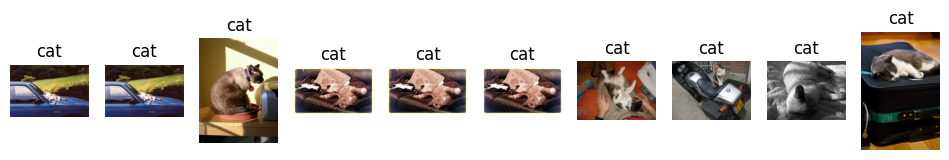

In [20]:
import matplotlib.pyplot as plt
from PIL import Image
import random

def show_samples(class_name, n=3):
    imgs = class_to_images[class_name][:n]
    plt.figure(figsize=(12,4))
    for i, img_name in enumerate(imgs):
        img_path = os.path.join(IMAGE_DIR, img_name)
        img = Image.open(img_path)
        plt.subplot(1, n, i+1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(class_name)
    plt.show()

# Example:
show_samples("cat", 10)


In [15]:
import cv2
import numpy as np
from ultralytics import YOLO
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from PIL import Image
import requests


In [5]:
# Load trained YOLO model
yolo_model = YOLO("best_yolo_model.pt")   # update path if needed

# Load best CNN model
cnn_model = load_model("mobilenet_finetuned_final.h5")  # or efficientnet model


In [7]:
import tensorflow as tf
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "smartvision_dataset/classification/train",
    image_size=(224, 224),
    batch_size=32,
    label_mode="categorical",
    shuffle=True
)
CLASS_NAMES = train_ds.class_names
NUM_CLASSES = len(CLASS_NAMES)

print("CNN Classes:", CLASS_NAMES)


Found 1750 files belonging to 25 classes.
CNN Classes: ['airplane', 'bed', 'bench', 'bicycle', 'bird', 'bottle', 'bowl', 'bus', 'cake', 'car', 'cat', 'chair', 'couch', 'cow', 'cup', 'dog', 'elephant', 'horse', 'motorcycle', 'person', 'pizza', 'potted plant', 'stop sign', 'traffic light', 'truck']


In [8]:
CNN_CLASS_MAP = {i: name for i, name in enumerate(train_ds.class_names)}


In [35]:
YOLO_CONF_THRESHOLD = 0.45   # trust YOLO above this
IMG_SIZE = 224               # CNN input size
CNN_CONF_THRESHOLD = 0.65


In [36]:
def classify_with_cnn(crop_img):
    crop_img = cv2.resize(crop_img, (IMG_SIZE, IMG_SIZE))
    crop_img = cv2.cvtColor(crop_img, cv2.COLOR_BGR2RGB)
    crop_img = preprocess_input(crop_img.astype(np.float32))
    crop_img = np.expand_dims(crop_img, axis=0)

    preds = cnn_model.predict(crop_img, verbose=0)
    class_id = int(np.argmax(preds))
    confidence = float(np.max(preds))

    return CNN_CLASS_MAP[class_id], confidence
import requests
import cv2
import numpy as np
from PIL import Image
from io import BytesIO

def load_image_any_source(source):
    if source.startswith("http"):
        headers = {"User-Agent": "Mozilla/5.0"}
        response = requests.get(source, headers=headers, timeout=15)
        response.raise_for_status()
        img = Image.open(BytesIO(response.content)).convert("RGB")
        img = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    else:
        img = cv2.imread(source)

    if img is None:
        raise ValueError("❌ Failed to load image")

    return img
def run_inference(image_path):
    image = load_image_any_source(image_path)
    output = image.copy()
    h, w = image.shape[:2]

    results = yolo_model.predict(
        source=image,
        conf=0.25,
        iou=0.5,
        imgsz=640,
        verbose=False
    )[0]

    print("\n🔍 FINAL DETECTIONS")
    print("=" * 50)

    for i, box in enumerate(results.boxes):
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        yolo_conf = float(box.conf[0])
        yolo_class_id = int(box.cls[0])
        yolo_label = SELECTED_CLASS_NAMES[yolo_class_id]

        # Clip bounding box
        x1, y1 = max(0, x1), max(0, y1)
        x2, y2 = min(w, x2), min(h, y2)

        crop = image[y1:y2, x1:x2]
        if crop.size == 0:
            continue

        # 🧠 CNN PRIMARY
        cnn_label, cnn_conf = classify_with_cnn(crop)

        if cnn_conf >= CNN_CONF_THRESHOLD:
            final_label = cnn_label
            final_conf = cnn_conf
            source_used = "CNN"
        else:
            final_label = yolo_label
            final_conf = yolo_conf
            source_used = "YOLO"

        # Console output
        print(f"Object {i+1}:")
        print(f"  YOLO  → {yolo_label} ({yolo_conf:.2f})")
        print(f"  FINAL → {final_label} ({final_conf:.2f}) [{source_used}]")
        print("-" * 50)

        # Draw
        cv2.rectangle(output, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(
            output,
            f"{final_label} {final_conf:.2f}",
            (x1, max(0, y1 - 8)),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.6,
            (0, 255, 0),
            2
        )

    return output


In [64]:
result_img = run_inference("C:\\Projects\\Smart_Vision\\smartvision_dataset\\classification\\test\\airplane\\airplane_test_0002.jpg")

cv2.imshow("Final Output", result_img)
cv2.waitKey(0)
cv2.destroyAllWindows()



🔍 FINAL DETECTIONS
Object 1:
  YOLO  → airplane (0.71)
  FINAL → airplane (0.98) [CNN]
--------------------------------------------------


In [63]:
result_img = run_inference(
    "https://upload.wikimedia.org/wikipedia/commons/thumb/f/f6/Plotted_Plants_also_called_Masetas_in_Reina_Mercedes%2C_Isabela.jpg/640px-Plotted_Plants_also_called_Masetas_in_Reina_Mercedes%2C_Isabela.jpg"
)

cv2.imshow("Final Output", result_img)
cv2.waitKey(0)
cv2.destroyAllWindows()


HTTPError: 429 Client Error: Use thumbnail steps listed on https://w.wiki/GHai. Please contact noc@wikimedia.org for further information (a765913) for url: https://upload.wikimedia.org/wikipedia/commons/thumb/f/f6/Plotted_Plants_also_called_Masetas_in_Reina_Mercedes%2C_Isabela.jpg/640px-Plotted_Plants_also_called_Masetas_in_Reina_Mercedes%2C_Isabela.jpg

In [66]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# Load trained CNN
cnn_model = load_model("models/mobilenet_finetuned_final.h5")
CNN_CONF_THRESHOLD = 0.65
# Load class names EXACTLY as used during training
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "smartvision_dataset/classification/train",
    image_size=(224, 224),
    batch_size=32,
    shuffle=False
)

CLASS_NAMES = train_ds.class_names
IMG_SIZE = 224

print("CNN Classes:", CLASS_NAMES)
def predict_with_cnn(image_path):
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError("Image not found")

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

    img = preprocess_input(img.astype(np.float32))
    img = np.expand_dims(img, axis=0)

    preds = cnn_model.predict(img, verbose=0)[0]

    class_id = int(np.argmax(preds))
    confidence = float(np.max(preds))

    return CLASS_NAMES[class_id], confidence
label, conf = predict_with_cnn(
    "smartvision_dataset/classification/test/airplane/airplane_test_0002.jpg"
)

print(f"Prediction: {label} ({conf:.2f})")


Found 1750 files belonging to 25 classes.
CNN Classes: ['airplane', 'bed', 'bench', 'bicycle', 'bird', 'bottle', 'bowl', 'bus', 'cake', 'car', 'cat', 'chair', 'couch', 'cow', 'cup', 'dog', 'elephant', 'horse', 'motorcycle', 'person', 'pizza', 'potted plant', 'stop sign', 'traffic light', 'truck']
Prediction: airplane (0.96)
